In [168]:
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

### Identifying possible X candidates against y (super bowl appearance and super bowl win)

In [82]:
defensive_df = pd.read_csv('../data/cleaned/2017-2021_aggregated_team_defensive_stats_with_sb.csv')
defensive_df

,year,stat_type,team,forced_fumbles,fumble_recoveries,fumble_recovery_td,reception_fumble,rush_fumble,pass_attempt,pass_cmp,...,4th_att,4th_md,rec_1st_all,rec_1st%_all,rush_1st_all,rush_1st%_all,total_plays,year_team,sb_winner,sb_appearance
0,2018,defense,49ers,11,5,0,4,6,542,344,...,17,10,195,56.7,104,23.4,1023,2018_49ers,0,0
1,2018,defense,Bears,18,9,1,4,5,615,377,...,28,16,186,49.3,67,19.8,1004,2018_Bears,0,0
2,2018,defense,Bengals,10,6,2,3,3,584,389,...,17,11,221,56.8,125,26.8,1084,2018_Bengals,0,0
3,2018,defense,Bills,21,11,0,4,10,492,313,...,11,6,157,50.2,111,25.2,968,2018_Bills,0,0
4,2018,defense,Broncos,13,10,0,3,6,549,353,...,11,6,197,55.8,85,19.8,1022,2018_Broncos,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2021,defense,Seahawks,9,7,0,1,5,658,443,...,31,13,240,54.2,124,24.4,1201,2021_Seahawks,0,0
156,2021,defense,Steelers,18,9,0,7,7,563,355,...,24,13,186,52.4,144,28.9,1116,2021_Steelers,0,0
157,2021,defense,Texans,16,8,0,4,10,546,363,...,19,11,218,60.1,135,25.8,1101,2021_Texans,0,0
158,2021,defense,Titans,13,6,1,7,4,628,395,...,24,14,204,51.6,90,24.5,1039,2021_Titans,0,0


In [83]:
defensive_df['sb_winner'] = defensive_df['sb_winner'].astype(bool)
defensive_df['sb_appearance'] = defensive_df['sb_appearance'].astype(bool)

In [84]:
# Splitting dataframe to check numerical columns for statistical difference between means to identify 
# potential X candidates for logisitc regression

defensive_sb_app = defensive_df.loc[defensive_df['sb_appearance'] == True].select_dtypes(np.number)
defensive_nosb_app = defensive_df.loc[defensive_df['sb_appearance'] == False].select_dtypes(np.number)
display(defensive_sb_app.shape)
display(defensive_nosb_app.shape)

(10, 48)

(150, 48)

In [85]:
# Checking degree of normal distribution for numerical columns to consider when looking for significant difference 
# between various population means

for col in defensive_nosb_app.select_dtypes(np.number).columns:
    stat, pval = st.normaltest(defensive_nosb_app[col])
    if pval > 0.975:
        print(col, stat, pval)
    elif pval < 0.025:
        print(col, stat, pval)
print('/n')
for col in defensive_sb_app.select_dtypes(np.number).columns:
    stat, pval = st.normaltest(defensive_sb_app[col])
    if pval > 0.975:
        print(col, stat, pval)
    elif pval < 0.025:
        print(col, stat, pval)

year 108.9918957048916 2.1513474772124718e-24
fumble_recovery_td 49.14683315337764 2.1276528978139807e-11
reception_fumble 11.928844385146638 0.0025685282934255435
rush_td 15.8233382139905 0.00036644243823465156
rush_20+ 20.28046970621588 3.9459534542918395e-05
rush_40+ 20.342820777004306 3.8248340337508586e-05
int_td 15.927186414814166 0.0003479007891770097
int_yds 8.4320904425152 0.014756889488830064
SFTY 40.758633111181034 1.4105070946861231e-09
/n
fumble_recovery_td 8.067546329668009 0.017707390842496836
pass_td 8.170506485345058 0.0168188795186067
opp_qb_rate 21.53932839303407 2.1027820810452017e-05
pass_1st 8.835285673182934 0.012062632395416202
pass_1st% 8.899378557738487 0.01168219631175743
rush_20+ 0.0009657092936791859 0.9995172619087048
int_yds 9.689639955745971 0.007869033927709705
3rd_md 12.081782682587942 0.0023794370775936527
rec_1st_all 8.835285673182934 0.012062632395416202


/Users/HenrySoysa/Desktop/Ironhack/Week_5/Mid_bootcamp_project/nfl_venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [176]:
# Function for looking for significant difference between two populations' means. 
def ttest_ind_2(df1: pd.DataFrame, y: str, y_val, y_val2, random_state: int, significance_level: float=0.05):
    """
    Function: Split dataframes based on input in y column (binary) and compare statistical difference between each numerical column of split dataframe. 
    This is is done in order to identify potential X candidates for a logistic regression model to predict y outcomes. 
    Inputs: dataframe, name of y column, potential y value 1, potential y value 2, random state for scipy.stats.ttest_ind()
    Outputs: List of column names from dataframe that fall into the rejection zones and can be stated have means which are significantly different 
    from one another across y_value split
    """
    df1_num = df1.loc[df1[y] == y_val].select_dtypes(np.number)
    df2_num = df1.loc[df1[y] == y_val2].select_dtypes(np.number)
    for col in df1_num.columns:
        stat, pval = st.ttest_ind(df1_num[col], df2_num[col], axis=0, random_state=random_state)
        if pval > 1-(significance_level/2):
            print(col, stat, pval)
        elif pval < (significance_level/2):
            print(col, stat, pval)

In [283]:
# identifying potential X candidates for appearing in a super bowl (win or lose)
ttest_ind_2(defensive_df, 'sb_appearance', True, False, 9)

year 0.0 1.0
rush_att -2.6545076268991243 0.008755154814211187
rush_td -2.457023444957893 0.015090868797000936
rec_yds -0.011103310641426846 0.9911550292367656
total_sack -3.138259871223912 0.002028155161349757


In [90]:
# Creating list of columns as X candidates to use for logistic regression model. 
potential_x_candidates_app_with_y = ['rush_att', 'rush_td', 'rec_yds', 'total_sack', 'sb_appearance']

In [91]:
defensive_df_appearance = defensive_df[potential_x_candidates_app_with_y]

### Logistic Regression for Defense appearing in a superbowl

In [ ]:
# Split into X and y
X = defensive_df_appearance.drop(columns='sb_appearance')
y = defensive_df_appearance['sb_appearance']

In [100]:
# train test data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [101]:
# no categorical data in X. Only numerical. 
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)

In [ ]:
# No categorical column encoding required. 

In [110]:
from sklearn.preprocessing import PowerTransformer

trans = PowerTransformer()

trans.fit(X_train_num)

X_train_transf = trans.transform(X_train_num)
X_test_transf = trans.transform(X_test_num)

X_train_transf_df = pd.DataFrame(X_train_transf, columns=X_train_num.columns, index=X_train_num.index)
X_test_transf_df = pd.DataFrame(X_test_transf, columns=X_train_num.columns, index=X_test_num.index)

X_train_transf_df.head()

,rush_att,rush_td,rec_yds,total_sack
112,-0.037866,-1.280790,-2.367872,-1.370596
2,0.837246,0.608605,1.500654,-0.087807
55,0.316322,0.198264,-0.313925,-1.585149
118,0.056504,-0.735712,-0.003332,-1.370596
36,-0.108604,-1.280790,-0.587501,0.276987


In [165]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_transf_df)

X_train_scaled =  scaler.transform(X_train_transf_df)
X_test_scaled = scaler.transform(X_test_transf_df)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_transf_df.columns, index=X_train_transf_df.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train_transf_df.columns, index=X_test_transf_df.index)

X_train_scaled_df.head()

,rush_att,rush_td,rec_yds,total_sack
112,0.485515,0.245802,0.011568,0.238582
2,0.687203,0.588688,0.767279,0.506637
55,0.567145,0.514220,0.412803,0.193748
118,0.507264,0.344723,0.473477,0.238582
36,0.469211,0.245802,0.359361,0.582866


####  Training Logistic Regression Models for Super Bowl Appearance

In [166]:
# Training model with saga as solver. 
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='auto')

classification.fit(X_train_scaled_df, y_train)

y_test_pred = classification.predict(X_test_scaled_df)

from sklearn.metrics import accuracy_score

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TEST set is: 0.92
The precision in the TEST set is: 0.00
The recall in the TEST set is: 0.00
The F1 in the TEST set is: 0.00
The Kappa in the TEST set is: 0.00


/Users/HenrySoysa/Desktop/Ironhack/Week_5/Mid_bootcamp_project/nfl_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [161]:
# Training model wtih lbfgs as solver to see if there is any difference between scores. 
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='auto')

classification.fit(X_train_scaled_df, y_train)

y_pred_test = classification.predict(X_test_scaled_df)

from sklearn.metrics import accuracy_score

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TEST set is: 0.92
The precision in the TEST set is: 0.00
The recall in the TEST set is: 0.00
The F1 in the TEST set is: 0.00
The Kappa in the TEST set is: 0.00


/Users/HenrySoysa/Desktop/Ironhack/Week_5/Mid_bootcamp_project/nfl_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


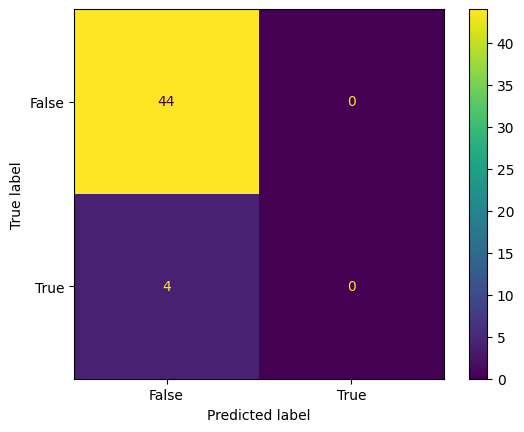

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_)
disp.plot()
plt.show()

sb_appearance
False    44
True      4
Name: count, dtype: int64

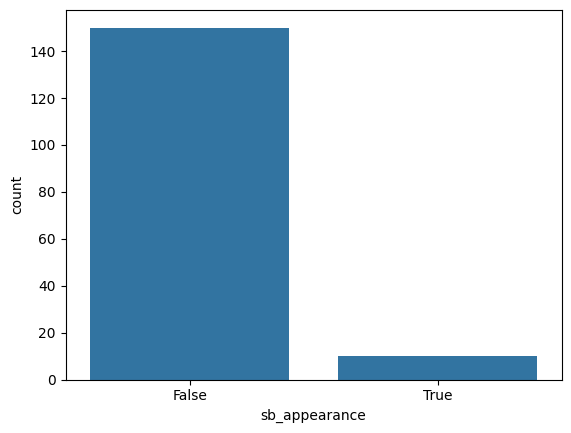

In [167]:
# Looking at dataset imbalance. 
sns.countplot(data=defensive_df_appearance, x='sb_appearance')
len(defensive_df_appearance.loc[defensive_df_appearance['sb_appearance'] == True])
# Based on True values only seen in 6% of dataset, oversampling of true rows required. 
y_test.value_counts()

#### Addressing imbalance of data for superbowl appearances and retraining logistic regression model

In [156]:
# Using SMOTE method to balance TRUE and FALSE values in sb_appearance column
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=100,k_neighbors=5)

X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train_scaled_df, y_train)

In [164]:
print(len(X_train_scaled_df), len(X_train_SMOTE))
y_train_SMOTE.value_counts()

112 212


sb_appearance
False    106
True     106
Name: count, dtype: int64

In [157]:
# Re-running the logistic regression model with OVER sampled df for TRUE values. 
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_test_SMOTE = lr.predict(X_test_scaled_df)

In [158]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test_SMOTE)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test_SMOTE)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test_SMOTE)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test_SMOTE)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test_SMOTE)))

The accuracy in the TEST set is: 0.71
The precision in the TEST set is: 0.14
The recall in the TEST set is: 0.50
The F1 in the TEST set is: 0.22
The Kappa in the TEST set is: 0.11


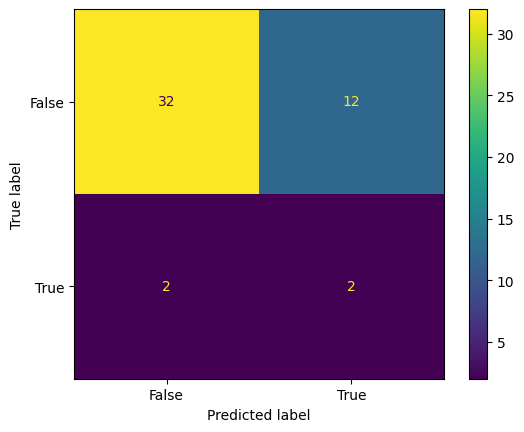

In [159]:
cm_test = confusion_matrix(y_test, y_pred_test_SMOTE)

disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_)
disp.plot()
plt.show()

#### Training Logistic Regression Models for Super Bowl Win

In [ ]:
defensive_sb_win = defensive_df.loc[defensive_df['sb_win'] == 1].select_dtypes(np.number)

In [177]:
# identifying potential X candidates for winning in a super bowl
# using significance level as 0.1 due to small size of dataset
ttest_ind_2(defensive_df, 'sb_winner', True, False, 9, 0.1)

year 0.0 1.0
reception_fumble 2.0312898823041303 0.043901652337641026
pass_attempt 2.1110632241713967 0.03634081820893282
rush_att -2.7936812739817616 0.005856148534420825
rush_td -1.998733864621806 0.04735223696124111
3rd_md -2.01380378579999 0.04572736716254495


In [305]:
potential_x_candidates_win_with_y = ['rush_att', 'reception_fumble', 'pass_attempt', '3rd_md', 'sb_winner']

In [306]:
defensive_df_winner = defensive_df[potential_x_candidates_win_with_y]

### Logistic Regression for Defense winning in a superbowl

In [307]:
# Split into X and y
X = defensive_df_winner.drop(columns='sb_winner')
y = defensive_df_winner['sb_winner']

In [308]:
# train test data split

# checking y_split value counts to ensure there is enough data for the model to be trained on regarding super bowl winners and their corresponding statistics

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)
y_test.value_counts(), y_train.value_counts()

(sb_winner
 False    47
 True      1
 Name: count, dtype: int64,
 sb_winner
 False    108
 True       4
 Name: count, dtype: int64)

In [309]:
# no categorical data in X. Only numerical. 
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)

In [310]:
# No categorical column encoding required. 

In [311]:
from sklearn.preprocessing import PowerTransformer

trans = PowerTransformer()

trans.fit(X_train_num)

X_train_transf = trans.transform(X_train_num)
X_test_transf = trans.transform(X_test_num)

X_train_transf_df = pd.DataFrame(X_train_transf, columns=X_train_num.columns, index=X_train_num.index)
X_test_transf_df = pd.DataFrame(X_test_transf, columns=X_train_num.columns, index=X_test_num.index)

X_train_transf_df.head()

,rush_att,reception_fumble,pass_attempt,3rd_md
4,0.029115,-0.251701,-0.266864,0.045085
133,0.211207,0.195749,0.379368,0.396358
136,1.763053,0.604037,-0.020996,2.106978
43,-0.482903,-0.251701,0.217110,-1.364456
124,-1.012615,0.604037,-1.627727,-0.876853


In [312]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_transf_df)

X_train_scaled =  scaler.transform(X_train_transf_df)
X_test_scaled = scaler.transform(X_test_transf_df)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_transf_df.columns, index=X_train_transf_df.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train_transf_df.columns, index=X_test_transf_df.index)

X_train_scaled_df.head()

,rush_att,reception_fumble,pass_attempt,3rd_md
4,0.538273,0.392511,0.430389,0.568836
133,0.579092,0.488296,0.566720,0.632851
136,0.926966,0.575697,0.482258,0.944590
43,0.423495,0.392511,0.532490,0.311966
124,0.304750,0.575697,0.143299,0.400825


####  Training Logistic Regression Models for Super Bowl Win

In [313]:
# Training model with saga as solver. 
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='auto')

classification.fit(X_train_scaled_df, y_train)

y_pred_test = classification.predict(X_test_scaled_df)

from sklearn.metrics import accuracy_score

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TEST set is: 0.98
The precision in the TEST set is: 0.00
The recall in the TEST set is: 0.00
The F1 in the TEST set is: 0.00
The Kappa in the TEST set is: 0.00


/Users/HenrySoysa/Desktop/Ironhack/Week_5/Mid_bootcamp_project/nfl_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [314]:
# Training model wtih lbfgs as solver to see if there is any difference between scores. 

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='auto')

classification.fit(X_train_scaled_df, y_train)

y_pred_test = classification.predict(X_test_scaled_df)

from sklearn.metrics import accuracy_score

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test)))

The accuracy in the TEST set is: 0.98
The precision in the TEST set is: 0.00
The recall in the TEST set is: 0.00
The F1 in the TEST set is: 0.00
The Kappa in the TEST set is: 0.00


/Users/HenrySoysa/Desktop/Ironhack/Week_5/Mid_bootcamp_project/nfl_venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


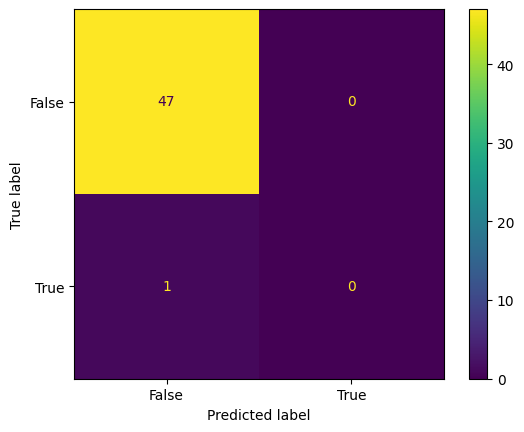

In [315]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_test = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_)
disp.plot()
plt.show()

(sb_winner
 False    47
 True      1
 Name: count, dtype: int64,
 sb_winner
 False    108
 True       4
 Name: count, dtype: int64)

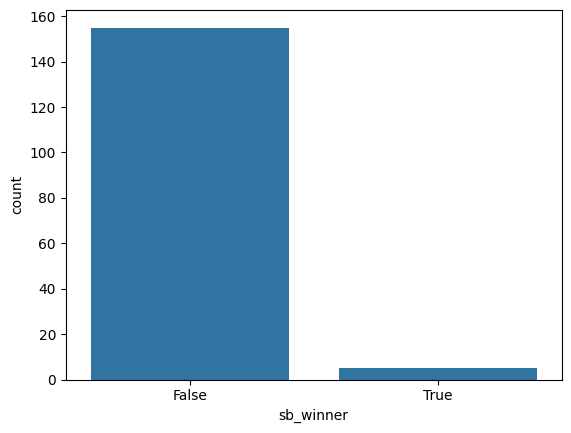

In [316]:
# Looking at dataset imbalance. 
sns.countplot(data=defensive_df_winner, x='sb_winner')
len(defensive_df_appearance.loc[defensive_df_winner['sb_winner'] == True])
# Based on True values only seen in 6% of dataset, oversampling of true rows required. 
y_test.value_counts(), y_train.value_counts()

#### Addressing imbalance of data for superbowl appearances and retraining logistic regression model

In [317]:
# Using SMOTE method to balance TRUE and FALSE values in sb_appearance column

# Using k_neighbors = 2 here due to severely low sample size. 
# What this likely means, the model will likely be less accurate at predicting real scenarios of super bowl wins, unless more data from 
# past years is fed into the model. 

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=9, k_neighbors=3)

X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train_scaled_df, y_train)

In [318]:
print(len(X_train_scaled_df), len(X_train_SMOTE))
y_train_SMOTE.value_counts()

112 216


sb_winner
False    108
True     108
Name: count, dtype: int64

In [319]:
# Re-running the logistic regression model with OVER sampled df for TRUE values. 
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_test_SMOTE = lr.predict(X_test_scaled_df)

In [320]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

print("The accuracy in the TEST set is: {:.2f}".format(accuracy_score(y_test,y_pred_test_SMOTE)))
print("The precision in the TEST set is: {:.2f}".format(precision_score(y_test,y_pred_test_SMOTE)))
print("The recall in the TEST set is: {:.2f}".format(recall_score(y_test,y_pred_test_SMOTE)))
print("The F1 in the TEST set is: {:.2f}".format(f1_score(y_test,y_pred_test_SMOTE)))
print("The Kappa in the TEST set is: {:.2f}".format(cohen_kappa_score(y_test,y_pred_test_SMOTE)))

The accuracy in the TEST set is: 0.85
The precision in the TEST set is: 0.12
The recall in the TEST set is: 1.00
The F1 in the TEST set is: 0.22
The Kappa in the TEST set is: 0.19


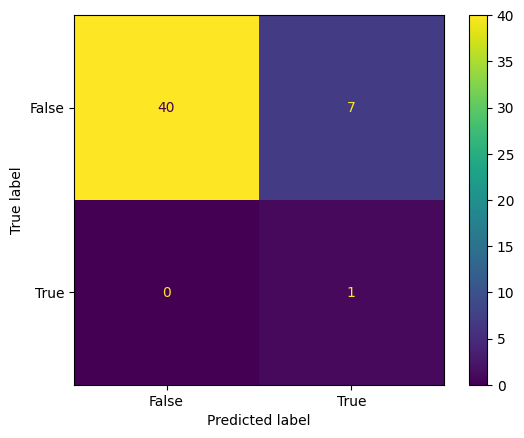

In [321]:
cm_test = confusion_matrix(y_test, y_pred_test_SMOTE)

disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_)
disp.plot()
plt.show()

### Conclusion for predicting Super Bowl wins and appearances
In conclusion of predicting super bowl wins and appearances for NFL teams based on their regular season defensive statistics, an overall kappa score for both models was quite low, and there had to be significant oversampling performed in order to improve overall accuracy and kappa score for the models. 

#### Super Bowl Winner Prediction
Due to the 1 winner per year in the 5 years dataset, this makes the overall prediciton accuracy difficult to improve without additional years of data. 
However, what can be seen is the main variables for helping predict an NFL's teams likelihood to win a super bowl from defensive statistics are: 

- rush_att: Number of attempts from opposing teams who try to run the ball against the team's defence.
- reception_fumble: Number of times the defence has caused a receiver to fumble (lose possession of) the ball after catching a pass. The assumption here being that the higher this number of reception fumbles, the higher the rate of turnovers from this team's defence, and then the lower the likelihood of this defence conceding points and the higher the chance of this defence winning the superbowl. 
- pass_attempt: Number of pass attempts against the team's defence. 
- 3rd_md: Number of 3rd downs converted against the team's defence. The assumption here is that the lower this statistic, the better the team's defence, and therefore the higher likelihood this team win's a super bowl

#### Super Bowl Appearance Prediction
Being able to play in a super bowl is the secondary goal of every NFL team, after of course winning said Super Bowl. As this dataset contained more super bowl appearances than super bowl winners from the same time frame, naturally, then it made sense the model was better able to come up with accurate predictions after oversampling with SMOTE and 3 k_nearest neighbors.

The main determinants for being able to predict a team's super bowl appearance included: 

- rush_att: the number of rushing attempts that defence faced throughout the regular season. 
- rush_td: the number of rushing touchdowns that defence conceded throughou the regular season. 
- rec_yds: the number of reception yards that defence conceded throughout the season. 
- total_sack: the number of sacks recorded by the defence throughout the regular season.
The assumptions being that all of these variables, apart from sacks which would be the opposite, would be that the lower the number for the defence, the higher the likelihood that the defence will be playing in the superbowl. 